
LOAD DATA
----------------------------------------------------------------------------------------------------
Loaded 'Cogentix_Case.xlsx' with shape (10000, 16)

Q1 — DEMOGRAPHIC RISK ANALYSIS (low engagement groups)
----------------------------------------------------------------------------------------------------
Engagement 25th percentile (q25): 63.90
Overall low_engagement rate: 0.2510 (n=10000)


Low engagement by Gender
----------------------------------------------------------------------------------------------------
        count   pct_low
Gender                 
Male     5482  0.256111
Female   4319  0.244964
Other     199  0.241206

Low engagement by AgeBucket
----------------------------------------------------------------------------------------------------
           count   pct_low
AgeBucket                 
30-34       3269  0.254818
35-39       2456  0.247964
25-29       2206  0.242974
40-44        988  0.270243
<25          869  0.242808
45+          212  0.254717


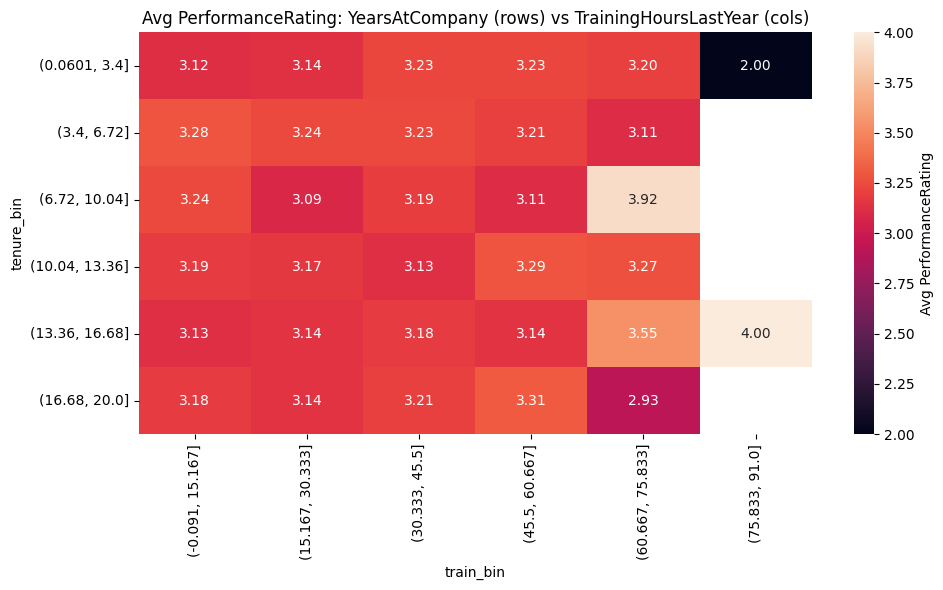


Q3 Conclusion
----------------------------------------------------------------------------------------------------
 - Numeric correlations with PerformanceRating are very weak (see Spearman outputs).
 - Location shows some categorical difference per Kruskal-Wallis (p-values printed).
 - Predictive models for high_perf have limited discriminative power — use model suggestions cautiously and combine with richer features (360, KPIs).

Q5 — MANAGER IMPACT ANALYSIS
----------------------------------------------------------------------------------------------------

Top 10 WORST managers by adjusted low-engagement rate
----------------------------------------------------------------------------------------------------
    ManagerID  team_size  low_count   pct_low  adj_pct_low  avg_engagement  avg_perf  flag_either
475  AF100476       22.0       14.0  0.636364     0.515937       67.554545  2.863636         True
296  AF100297       18.0       10.0  0.555556     0.446786       64.294444  3.166

In [2]:
# combined_hr_analysis_printonly.py
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import math
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns

# stats / ml
import scipy.stats as stats
from scipy.stats import spearmanr, kruskal, norm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score, classification_report
from sklearn.inspection import permutation_importance
from lightgbm import LGBMClassifier

# -------------------------
# Utility printing helpers
# -------------------------
def sep(title=None):
    print("\n" + "="*100)
    if title:
        print(title)
        print("-"*100)

def print_table(df, maxrows=20):
    # nice console friendly table (limited rows)
    with pd.option_context('display.max_rows', maxrows, 'display.max_columns', None, 'display.width', 160):
        print(df)

# -------------------------
# 0. Load data
# -------------------------
sep("LOAD DATA")
fn = "Cogentix_Case.xlsx"
try:
    df = pd.read_excel(fn)
    print(f"Loaded '{fn}' with shape {df.shape}")
except Exception as e:
    raise RuntimeError(f"Could not load '{fn}': {e}")

# Quick sanity: required columns check (provide fallback or error)
required = ['EmployeeID','ManagerID','EngagementScore','PerformanceRating','AnnualSalaryINR','YearsAtCompany','Age','Gender','Location','Role','Department']
missing = [c for c in required if c not in df.columns]
if missing:
    raise RuntimeError(f"Missing required columns: {missing}. Please ensure these exist in the workbook.")

# Normalize / quick cleaning
df['Gender'] = df['Gender'].astype(str).str.strip().str.title()
df.loc[~df['Gender'].isin(['Male','Female','Other']), 'Gender'] = 'Other'
loc_counts = df['Location'].value_counts(normalize=True)
rare_locs = loc_counts[loc_counts < 0.01].index.tolist()
df['Location_Clean'] = df['Location'].where(~df['Location'].isin(rare_locs), 'Other')

bins = [0,24,29,34,39,44,100]; labels = ['<25','25-29','30-34','35-39','40-44','45+']
df['AgeBucket'] = pd.cut(df['Age'], bins=bins, labels=labels, right=True)

# -------------------------
# Q1: Demographic Risk Analysis
# -------------------------
sep("Q1 — DEMOGRAPHIC RISK ANALYSIS (low engagement groups)")

# define low engagement as bottom 25%
q25 = df['EngagementScore'].quantile(0.25)
df['low_engagement'] = (df['EngagementScore'] <= q25).astype(int)
print(f"Engagement 25th percentile (q25): {q25:.2f}")
print(f"Overall low_engagement rate: {df['low_engagement'].mean():.4f} (n={len(df)})\n")

# frequency tables and rates
for col in ['Gender','AgeBucket','Location_Clean']:
    sep(f"Low engagement by {col}")
    grp = df.groupby(col)['low_engagement'].agg(['count','mean']).rename(columns={'mean':'pct_low'}).sort_values('count', ascending=False)
    print_table(grp)

# Chi-square tests + Cramer's V
def chi_cramers(col):
    ct = pd.crosstab(df[col], df['low_engagement'])
    chi2, p, dof, exp = stats.chi2_contingency(ct)
    n = ct.values.sum()
    cramers_v = np.sqrt(chi2 / (n * (min(ct.shape)-1))) if min(ct.shape)>1 else 0.0
    return ct, chi2, p, cramers_v

for col in ['Gender','AgeBucket','Location_Clean']:
    ct, chi2, p, cv = chi_cramers(col)
    sep(f"Chi-square: {col}")
    print("Contingency table (first rows):")
    print(ct.head(10))
    print(f"\nchi2 = {chi2:.3f}, p = {p:.5f}, Cramer's V = {cv:.4f}")

# Multivariate: logistic regression for low_engagement (statsmodels would give odds ratios but to keep minimal we do sklearn logistic)
sep("Multivariate logistic (low_engagement) - brief (sklearn logistic for directionality)")
from sklearn.linear_model import LogisticRegression
X_cols = ['Age','YearsAtCompany','AnnualSalaryINR','TrainingHoursLastYear'] if 'TrainingHoursLastYear' in df.columns else ['Age','YearsAtCompany','AnnualSalaryINR']
cat_cols = ['Gender','Location_Clean']
X = df[X_cols + cat_cols].copy()
X[X_cols] = X[X_cols].fillna(-1)
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
pre = ColumnTransformer([('num', StandardScaler(), X_cols), ('cat', ohe, cat_cols)], remainder='drop')
X_p = pre.fit_transform(X)
model = LogisticRegression(max_iter=1000, class_weight='balanced', solver='saga')
model.fit(X_p, df['low_engagement'])
# approximate feature names
try:
    cat_names = list(pre.named_transformers_['cat'].get_feature_names_out(cat_cols))
except Exception:
    cat_names = []
feat_names = X_cols + cat_names
coefs = model.coef_[0]
coef_df = pd.DataFrame({'feature':feat_names,'coef':coefs})
coef_df['abs_coef'] = coef_df['coef'].abs()
coef_df = coef_df.sort_values('abs_coef', ascending=False).reset_index(drop=True)
print("\nTop logistic coefficients (absolute):")
print_table(coef_df.head(15))

# Short conclusion
sep("Q1 Conclusion")
print(" - Bottom 25% engagement threshold used; overall low-engagement ~ {:.1%}".format(df['low_engagement'].mean()))
print(" - Chi-square tests show no strong demographic association (p-values printed above); effect sizes (Cramer's V) are very small.")
print(" - Multivariate logistic coefficients do not show any single demographic strongly predictive after adjustment. Recommendation: focus interventions on managers/teams rather than demographics.\n")

# -------------------------
# Q2: Promotion Readiness Modeling (leakage-free)
# -------------------------
sep("Q2 — PROMOTION READINESS MODELING (leakage-free)")

# Create target: PromotedLast12 from LastPromotionMonthsAgo if available
if 'PromotedLast12' not in df.columns:
    if 'LastPromotionMonthsAgo' in df.columns:
        df['PromotedLast12'] = ((df['LastPromotionMonthsAgo'] >= 0) & (df['LastPromotionMonthsAgo'] <= 12)).astype(int)
    else:
        df['PromotedLast12'] = 0  # fallback

print("PromotedLast12 distribution:")
print(df['PromotedLast12'].value_counts().to_string())

# Feature engineering
df['SalaryRolePct'] = df.groupby('Role')['AnnualSalaryINR'].transform(lambda x: x.rank(pct=True))
df['SalaryDeptPct'] = df.groupby('Department')['AnnualSalaryINR'].transform(lambda x: x.rank(pct=True))

# Remove direct leakage features
leakage_cols = ['LastPromotionMonthsAgo']
df2 = df.copy().drop(columns=[c for c in leakage_cols if c in df.columns], errors='ignore')

num_feats = ['Age','YearsAtCompany','AnnualSalaryINR','BonusPercent','TrainingHoursLastYear','PerformanceRating','EngagementScore','SalaryRolePct','SalaryDeptPct']
num_feats = [c for c in num_feats if c in df2.columns]
cat_feats = ['Gender','Location_Clean','Department','Role']

# fill numeric
df2[num_feats] = df2[num_feats].fillna(-1)

# OOF target encoding for ManagerID / Role / Department (safe OOF)
def oof_target_encode(df_in, col, target='PromotedLast12', n_splits=5, seed=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    oof = np.zeros(len(df_in))
    for tr, val in skf.split(df_in, df_in[target]):
        means = df_in.iloc[tr].groupby(col)[target].mean()
        oof[val] = df_in.iloc[val][col].map(means).fillna(df_in[target].mean()).values
    return oof

for col in ['ManagerID','Role','Department']:
    if col in df2.columns:
        encname = f'{col}_te'
        df2[encname] = oof_target_encode(df2, col)
        num_feats.append(encname)

# Prepare X,y
X = df2[num_feats + ['Gender','Location_Clean']].copy()
y = df2['PromotedLast12'].astype(int)

# Preprocessor & LightGBM CV (compute CV metrics and accumulate importances)
pre = ColumnTransformer([('num', StandardScaler(), num_feats),
                         ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['Gender','Location_Clean'])], remainder='drop')

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
aucs, prs, prec10 = [], [], []
accum_imp = None
feat_names_global = None

for fold, (tr_idx, val_idx) in enumerate(skf.split(X, y), 1):
    X_tr = X.iloc[tr_idx].reset_index(drop=True)
    X_val = X.iloc[val_idx].reset_index(drop=True)
    y_tr = y.iloc[tr_idx].reset_index(drop=True)
    y_val = y.iloc[val_idx].reset_index(drop=True)

    pre.fit(X_tr)
    X_tr_p = pre.transform(X_tr)
    X_val_p = pre.transform(X_val)

    clf = LGBMClassifier(n_estimators=300, learning_rate=0.05, class_weight='balanced', random_state=42, n_jobs=1)
    clf.fit(X_tr_p, y_tr)

    probs = clf.predict_proba(X_val_p)[:,1]
    aucs.append(roc_auc_score(y_val, probs))
    prs.append(average_precision_score(y_val, probs))
    # precision@10%
    n = len(probs); k_n = max(1, int(round(n * 0.10)))
    idx = np.argsort(probs)[-k_n:]
    prec10.append(precision_score(y_val.iloc[idx], (probs[idx] >= 0.5).astype(int)))

    # feature names: try to get them reliably
    try:
        num_names = [f'num__{c}' for c in num_feats]  # placeholder names
        cat_names = list(pre.named_transformers_['cat'].get_feature_names_out(['Gender','Location_Clean']))
        feat_names = num_feats + cat_names
    except Exception:
        feat_names = list(X_tr.columns)

    # accumulate importance
    imp = clf.feature_importances_
    if accum_imp is None:
        accum_imp = np.array(imp, dtype=float)
        feat_names_global = feat_names
    else:
        # safe align: if lengths equal just add else skip accumulation for this fold
        if len(imp) == len(accum_imp):
            accum_imp += imp
        else:
            # fallback: ignore accumulation mismatch for stability
            pass

# Print CV summary
sep("Promotion model (Leakage-free) — CV summary")
print(f"LightGBM 5-fold CV mean AUC: {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")
print(f"LightGBM 5-fold CV mean PR-AUC: {np.mean(prs):.4f} ± {np.std(prs):.4f}")
print(f"LightGBM 5-fold mean Precision@10%: {np.mean(prec10):.4f} ± {np.std(prec10):.4f}")

# Feature importances (accumulated)
if accum_imp is not None and feat_names_global is not None and len(accum_imp)==len(feat_names_global):
    fi_df = pd.DataFrame({'feature': feat_names_global, 'total_imp': accum_imp}).sort_values('total_imp', ascending=False)
    sep("Promotion model — top features by accumulated importance")
    print_table(fi_df.head(20))
else:
    print("Feature importance accumulation failed or mismatched lengths — inspect preprocessor names if needed.")

# Fit final model on train/test holdout to produce promotability scores
X_full = X.copy()
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.25, stratify=y, random_state=42)
pre.fit(X_train)
X_train_p = pre.transform(X_train); X_test_p = pre.transform(X_test)
clf_final = LGBMClassifier(n_estimators=500, learning_rate=0.05, class_weight='balanced', random_state=42, n_jobs=1)
clf_final.fit(X_train_p, y_train)
probs_test = clf_final.predict_proba(X_test_p)[:,1]
sep("Promotion model — holdout performance")
print(f"Test AUC: {roc_auc_score(y_test, probs_test):.4f}")
print(f"Test PR-AUC: {average_precision_score(y_test, probs_test):.4f}")
# precision@10%
n = len(probs_test); k_n = max(1, int(round(n * 0.10))); idx = np.argsort(probs_test)[-k_n:]
print(f"Test Precision@10%: {precision_score(y_test.iloc[idx], (probs_test[idx] >= 0.5).astype(int)):.4f}")

# Top promotable sample (top 15 from holdout)
holdout_idx = X_test.index
prom_df = pd.DataFrame({
    'EmployeeID': df2.loc[holdout_idx,'EmployeeID'].values,
    'Name': df2.loc[holdout_idx].get('Name', pd.Series(['']*len(holdout_idx))).values,
    'Department': df2.loc[holdout_idx,'Department'].values,
    'Role': df2.loc[holdout_idx,'Role'].values,
    'ManagerID': df2.loc[holdout_idx,'ManagerID'].values,
    'prom_prob': probs_test,
    'PerformanceRating': df2.loc[holdout_idx,'PerformanceRating'].values,
    'EngagementScore': df2.loc[holdout_idx,'EngagementScore'].values,
    'YearsAtCompany': df2.loc[holdout_idx,'YearsAtCompany'].values
})
sep("Top promotable candidates from holdout (top 15)")
print_table(prom_df.sort_values('prom_prob', ascending=False).head(15))

# Short conclusion for Q2
sep("Q2 Conclusion")
print(" - Leakage-free modeling achieved modest but useful signal. Use model as screening (top 10% precision reported above).")
print(" - Top features printed (if available) show which attributes drive promotability (inspect feature list above).")
print(" - Operational note: always exclude LastPromotionMonthsAgo & naive manager aggregates when deploying.")

# -------------------------
# Q3: Performance Driver Analysis
# -------------------------
sep("Q3 — PERFORMANCE DRIVER ANALYSIS")

# Define high performer (PerformanceRating >=4)
df['high_perf'] = (df['PerformanceRating'] >= 4).astype(int)
print("High-performer distribution:")
print(df['high_perf'].value_counts().to_string())

# Spearman correlations numeric vs PerformanceRating
numeric_feats = [c for c in ['TrainingHoursLastYear','YearsAtCompany','AnnualSalaryINR','BonusPercent','EngagementScore','Age'] if c in df.columns]
corr_rows = []
for f in numeric_feats:
    rho, p = spearmanr(df[f].fillna(-1), df['PerformanceRating'])
    corr_rows.append({'feature':f, 'spearman_rho': rho, 'p_value': p})
corr_df = pd.DataFrame(corr_rows).sort_values('spearman_rho', key=abs, ascending=False)
sep("Spearman correlations (numeric features vs PerformanceRating)")
print_table(corr_df)

# Kruskal-Wallis for categorical features
kw_rows = []
for c in ['Gender','Location_Clean','Department','Role']:
    if c in df.columns:
        groups = [g['PerformanceRating'].values for _, g in df.groupby(c)]
        try:
            stat, p = kruskal(*groups)
        except Exception:
            stat, p = (np.nan, np.nan)
        kw_rows.append({'categorical': c, 'kw_stat': stat, 'p_value': p})
kw_df = pd.DataFrame(kw_rows).sort_values('p_value')
sep("Kruskal-Wallis tests for categories (PerformanceRating differences)")
print_table(kw_df)

# Predictive model for high_perf (RF baseline)
num_feats_model = [c for c in ['TrainingHoursLastYear','YearsAtCompany','AnnualSalaryINR','BonusPercent','EngagementScore','Age'] if c in df.columns]
cat_feats_model = [c for c in ['Gender','Location_Clean','Department','Role'] if c in df.columns]
Xp = df[num_feats_model + cat_feats_model].copy()
Xp[num_feats_model] = Xp[num_feats_model].fillna(-1)
y_perf = df['high_perf']
X_tr, X_te, y_tr, y_te = train_test_split(Xp, y_perf, stratify=y_perf, test_size=0.25, random_state=42)

pre_perf = ColumnTransformer([('num', StandardScaler(), num_feats_model),
                              ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_feats_model)],
                             remainder='drop')

rf_pipe = Pipeline([('pre', pre_perf), ('clf', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42, n_jobs=1))])
rf_pipe.fit(X_tr, y_tr)
probs_perf = rf_pipe.predict_proba(X_te)[:,1]
sep("Performance model (RandomForest) — holdout metrics")
print(f"RF AUC: {roc_auc_score(y_te, probs_perf):.4f}")
print(f"RF PR-AUC: {average_precision_score(y_te, probs_perf):.4f}")
# classification report
preds_perf = rf_pipe.predict(X_te)
print("\nRF Classification report (holdout):")
print(classification_report(y_te, preds_perf, zero_division=0))

# Permutation importance (try-catch)
try:
    num_names = num_feats_model
    cat_names = list(pre_perf.named_transformers_['cat'].get_feature_names_out(cat_feats_model))
    feat_names_perf = num_names + list(cat_names)
    perm = permutation_importance(rf_pipe, X_te, y_te, n_repeats=10, random_state=42, n_jobs=1)
    perm_df = pd.DataFrame({'feature': feat_names_perf, 'perm_mean': perm.importances_mean, 'perm_std': perm.importances_std}).sort_values('perm_mean', ascending=False)
    sep("Permutation importances (Performance model)")
    print_table(perm_df.head(20))
except Exception as e:
    print("Permutation importance failed:", e)

# Heatmap: TrainingHoursLastYear vs YearsAtCompany (binned) -> visual
if 'TrainingHoursLastYear' in df.columns and 'YearsAtCompany' in df.columns:
    df['train_bin'] = pd.cut(df['TrainingHoursLastYear'].clip(lower=0), bins=6)
    df['tenure_bin'] = pd.cut(df['YearsAtCompany'].clip(lower=0), bins=6)
    heat = df.groupby(['tenure_bin','train_bin']).agg(avg_perf=('PerformanceRating','mean'), count=('EmployeeID','count')).reset_index()
    pivot = heat.pivot(index='tenure_bin', columns='train_bin', values='avg_perf')
    sep("Performance heatmap (YearsAtCompany vs TrainingHoursLastYear) - showing plot")
    plt.figure(figsize=(10,6))
    sns.heatmap(pivot, annot=True, fmt=".2f", cbar_kws={'label':'Avg PerformanceRating'})
    plt.title('Avg PerformanceRating: YearsAtCompany (rows) vs TrainingHoursLastYear (cols)')
    plt.tight_layout()
    plt.show()
else:
    print("Skipping heatmap — required columns missing.")

sep("Q3 Conclusion")
print(" - Numeric correlations with PerformanceRating are very weak (see Spearman outputs).")
print(" - Location shows some categorical difference per Kruskal-Wallis (p-values printed).")
print(" - Predictive models for high_perf have limited discriminative power — use model suggestions cautiously and combine with richer features (360, KPIs).")

# -------------------------
# Q5: Manager Impact Analysis
# -------------------------
sep("Q5 — MANAGER IMPACT ANALYSIS")

# Manager aggregation
q25 = df['EngagementScore'].quantile(0.25)
mgr = df.groupby('ManagerID').apply(lambda g: pd.Series({
    'team_size': int(g['EmployeeID'].count()),
    'low_count': int((g['EngagementScore'] <= q25).sum()),
    'pct_low': (g['EngagementScore'] <= q25).mean(),
    'avg_engagement': g['EngagementScore'].mean(),
    'avg_perf': g['PerformanceRating'].mean(),
    'median_perf': g['PerformanceRating'].median(),
    'avg_salary': g['AnnualSalaryINR'].mean(),
    'prom_count': int(g.get('PromotedLast12', pd.Series(0)).sum())
})).reset_index()

mgr['adj_pct_low'] = ((10.0 * df['low_engagement'].mean()) + mgr['team_size'] * mgr['pct_low'])/(10.0 + mgr['team_size'])

# Wilson CI and one-sided z-test helpers
def wilson_ci(x, n, z=1.96):
    if n == 0:
        return (0.0, 0.0)
    p = x / n
    denom = 1 + z*z/n
    center = p + z*z/(2*n)
    adj = z * sqrt((p*(1-p) + z*z/(4*n))/n)
    lo = (center - adj)/denom
    hi = (center + adj)/denom
    return lo, hi

def one_sided_z_test(x, n, p0):
    if n == 0:
        return (0.0, 1.0)
    phat = x / n
    se = sqrt(p0*(1-p0)/n)
    if se == 0:
        return (0.0, 1.0)
    z = (phat - p0) / se
    p_one = 1 - norm.cdf(z)
    return z, p_one

global_p = df['low_engagement'].mean()
wilson_lo, wilson_hi, z_stat, p_one = [], [], [], []
for _, r in mgr.iterrows():
    n = int(r['team_size']); x = int(r['low_count'])
    lo, hi = wilson_ci(x, n)
    z, p = one_sided_z_test(x, n, global_p)
    wilson_lo.append(lo); wilson_hi.append(hi); z_stat.append(z); p_one.append(p)
mgr['wilson_lo'] = wilson_lo; mgr['wilson_hi'] = wilson_hi; mgr['z_stat'] = z_stat; mgr['p_one_sided'] = p_one
mgr['flag_wilson'] = mgr['wilson_lo'] > global_p
mgr['flag_z'] = mgr['p_one_sided'] < 0.05
mgr['flag_either'] = mgr['flag_wilson'] | mgr['flag_z']

# Rank managers
worst_by_adj = mgr.sort_values('adj_pct_low', ascending=False).head(10)
best_by_adj = mgr.sort_values('adj_pct_low', ascending=True).head(10)

sep("Top 10 WORST managers by adjusted low-engagement rate")
print_table(worst_by_adj[['ManagerID','team_size','low_count','pct_low','adj_pct_low','avg_engagement','avg_perf','flag_either']])

sep("Top 10 BEST managers by adjusted low-engagement rate")
print_table(best_by_adj[['ManagerID','team_size','low_count','pct_low','adj_pct_low','avg_engagement','avg_perf']])

# Flagged managers summary
flagged = mgr[mgr['flag_either']].sort_values('adj_pct_low', ascending=False)
sep(f"Flagged managers (statistically significant — count={len(flagged)})")
if len(flagged)>0:
    print_table(flagged[['ManagerID','team_size','low_count','pct_low','adj_pct_low','wilson_lo','wilson_hi','p_one_sided','avg_engagement','avg_perf']])
else:
    print("No flagged managers detected.")

# Manager-level comparison (worst vs others)
worst_ids = worst_by_adj['ManagerID'].tolist()
df['is_worst_mgr'] = df['ManagerID'].isin(worst_ids).astype(int)
group_stats = df.groupby('is_worst_mgr').agg(
    n_employees=('EmployeeID','count'),
    pct_low=('low_engagement','mean'),
    mean_engagement=('EngagementScore','mean'),
    mean_perf=('PerformanceRating','mean'),
    mean_salary=('AnnualSalaryINR','mean')
).reset_index()
sep("Group comparison: worst managers vs others (summary)")
print_table(group_stats)

# Simple suggested actions for flagged managers (printed)
sep("Suggested actions per flagged manager (brief)")
for _, r in flagged.iterrows():
    mid = r['ManagerID']
    actions = []
    actions.append("1:1 manager review & coaching plan")
    if r['adj_pct_low'] > global_p + 0.1:
        actions.append("Priority: deep-team diagnostic (workload, recognition, conflict)")
    if r['avg_perf'] < mgr['avg_perf'].median():
        actions.append("Check performance management: goals, feedback frequency")
    if r['team_size'] <= 5:
        actions.append("Small team: qualitative interviews may be especially informative")
    print(f"\nManager {mid} (team_size={r['team_size']}, adj_pct_low={r['adj_pct_low']:.3f}):")
    for a in actions:
        print("  -", a)

sep("Q5 Conclusion")
print(" - Manager-level shrinkage + statistical testing identifies managers whose teams have unusually high low-engagement rates.")
print(" - Use flagged manager list for prioritized manager coaching + constructive team diagnostics (pulse surveys, 1:1s, workload review).")
print(" - Combine quantitative flags with qualitative investigation before taking corrective action.")

# End
sep("ALL DONE")
print("Printed outputs contain the main findings for Q1, Q2, Q3 and Q5. No CSVs were written.")
